In [1]:
# This is only needed if the notebook is run in VSCode
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

# Model evaluation

In [2]:
import sys
sys.path.append('../')
from fastai.vision.all import *
from mocatml.data import *
from mocatml.utils import *
from mocatml.models.utils import *
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
from mygrad import sliding_window_view
import wandb

In [3]:
my_setup()

os              : Linux-5.10.197-llgrid-x86_64-with-glibc2.35
python          : 3.9.15
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 1.13.1+cu116
device          : 0 gpus ([])
cpu cores       : 40
threads per cpu : 2
RAM             : 377.57 GB
GPU memory      : N/A


In [4]:
config = yaml2dict('./config/convgru/eval.yaml')
config

```json
{ 'data': { 'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy',
            'split_idx': 1},
  'device': 'cuda',
  'horizon': 4,
  'learner': { 'fname': 'learner.pkl',
               'path': 'tmp',
               'wandb': { 'dir': '~/Github/mocat-ml',
                          'download_path': 'wandb/artifacts/density-forecaster',
                          'enabled': False}},
  'lookback': 4,
  'mmap': True,
  'norm': {'mean': None, 'std': None},
  'sel_steps': None,
  'stride': 2,
  'wandb': { 'dir': None,
             'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [5]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cuda', index=0)

In [6]:
run = wandb.init(dir=ifnone(config.wandb.dir, '../'),
                 project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'data': {'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy', 'split_idx': 1}, 'device': 'cuda', 'horizon': 4, 'learner': {'wandb': {'enabled': False, 'dir': '~/Github/mocat-ml', 'download_path': 'wandb/artifacts/density-forecaster'}, 'path': 'tmp', 'fname': 'learner.pkl'}, 'lookback': 4, 'mmap': True, 'norm': {'mean': None, 'std': None}, 'sel_steps': None, 'stride': 2, 'wandb': {'dir': None, 'enabled': False, 'log_learner': False, 'mode': 'offline', 'group': None, 'project': 'mocatml'}}


In [7]:
wandb_api = wandb.Api()
if config.learner.wandb.enabled:
    ar = wandb_api.artifact(config.learner.path)
    lp = ar.download(root= Path(config.learner.wandb.dir).expanduser()/\
                            Path(config.learner.wandb.download_path))
    lp = lp/Path(config.learner.fname)
else:
    lp = Path(config.learner.path)/Path(config.learner.fname)
learn = load_learner(lp)
learn

In [8]:
if config.learner.wandb.enabled:
    run = ar.logged_by()
    config.lookback = run.config['lookback']
    config.horizon = run.config['horizon']
    config.sel_steps = run.config['sel_steps']
    config.stride = run.config['stride']
print(f'lookback: {config.lookback}, horizon: {config.horizon}, sel_steps: {config.sel_steps}, stride: {config.stride}')

lookback: 4, horizon: 4, sel_steps: None, stride: 2


In [9]:
X = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
if config.data.split_idx is not None:
    X = X[learn.splits[config.data.split_idx]]
X.shape

(20, 2436, 36, 99)

## Analysis on validation set (benchmark)
> same number of steps that those used in training

In [10]:
X_sw = np.lib.stride_tricks.sliding_window_view(X[:, :config.sel_steps], 
                                               config.lookback + config.horizon, 
                                               axis=1)[:,::config.stride,:]
samples_per_simulation = X_sw.shape[1]
X_sw = X_sw.transpose(0,1,4,2,3)
X_sw = X_sw.reshape(-1, *X_sw.shape[2:])
X_sw.shape

(24300, 8, 36, 99)

In [11]:
train_stats = (learn.dls.train.after_batch.mean, learn.dls.train.after_batch.std)
ds = DensityData(X_sw, lbk=config.lookback, h=config.horizon)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dl = TfmdDL(tl, bs=learn.dls.valid.bs, shuffle=False, num_workers=0, 
            after_batch=Normalize.from_stats(*train_stats))
xb,yb = dl.one_batch()
len(xb), xb[0].shape, len(yb), yb[0].shape

(4, torch.Size([32, 1, 36, 99]), 4, torch.Size([32, 1, 36, 99]))

In [12]:
#|hide
inps, preds, targs = learn.get_preds(dl=dl, with_input=True)
valid_loss = learn.loss_func(preds, targs)
print(f'valid_loss: {valid_loss}')

valid_loss: 142.96310424804688


In [13]:
#|hide
losses = learn.get_individual_losses(preds, targs)
losses.shape

torch.Size([24300])

In [14]:
#|hide
interp = Interpretation(learn, dl, losses)
_, best_idx = interp.top_losses(k=1, largest=False)
_, worst_idx = interp.top_losses(k=1, largest=True)
best_idx, worst_idx

(tensor([17028]), tensor([21869]))

[<AxesSubplot: title={'center': 'Epoch t+3'}, xlabel='rp [km]', ylabel='Am [m^2/kg]'>]

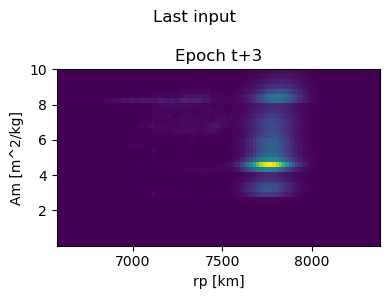

In [15]:
#|hide
inps_seq = DensitySeq.create(inps[i][worst_idx] for i in range(len(inps)))
inps_seq.show(title="Last input", epochs=[len(inps_seq)-1], 
              x_disc=RP_DISC, y_disc=AM_DISC, figsize=(4,3))


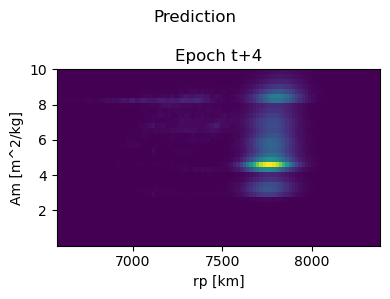

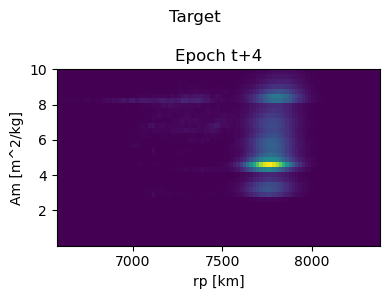

In [16]:
#|hide
learn.show_preds_at(worst_idx, p=preds, t=targs, epochs=[0], figsize=(4,3))

## Long term forecasting (full validation set)

Instead of slicing the dataset, we pass it unsliced, and let the iterative function 
advance through it, with a defined gap in the configuration.

We visualize predictions at half the whole sequence length, and at the end of the
sequence len.

In [17]:
ds_full = DensityData(X, lbk=config.lookback, h=config.horizon)
tl_full = TfmdLists(range(len(ds_full)), DensityTupleTransform(ds_full))
dl_full = TfmdDL(tl_full, bs=learn.dls.valid.bs, shuffle=False, num_workers=0, 
            after_batch=Normalize.from_stats(*train_stats))
xb,yb = dl_full.one_batch()
X.shape, dl_full.n, len(xb), xb[0].shape, len(yb), yb[0].shape

((20, 2436, 36, 99),
 20,
 4,
 torch.Size([20, 1, 36, 99]),
 4,
 torch.Size([20, 1, 36, 99]))

In [18]:
n_iter = X.shape[1]//config.horizon - 1
n_iter_half = n_iter//2
n_iter, n_iter_half

(608, 304)

Let's start with half the sequence

#|hide
inps, preds,targs,losses = learn.get_preds_iterative(dl=dl_full, n_iter=n_iter_half, 
                                                     track_losses=True, with_input=True)
len(inps), inps[0].shape, len(preds), preds[0].shape, len(targs), targs[0].shape, losses.shape

#|hide
learn.show_preds_at(0, p=preds, t=targs, with_targets=True, start_epoch=(n_iter_half-1))

Now let's do the full sequence

In [19]:
preds,targs,losses = learn.get_preds_iterative(dl=dl_full, n_iter=n_iter, track_losses=True)
len(preds), preds[0].shape, len(targs), targs[0].shape, losses.shape

(4,
 torch.Size([20, 1, 36, 99]),
 4,
 torch.Size([20, 1, 36, 99]),
 torch.Size([608]))

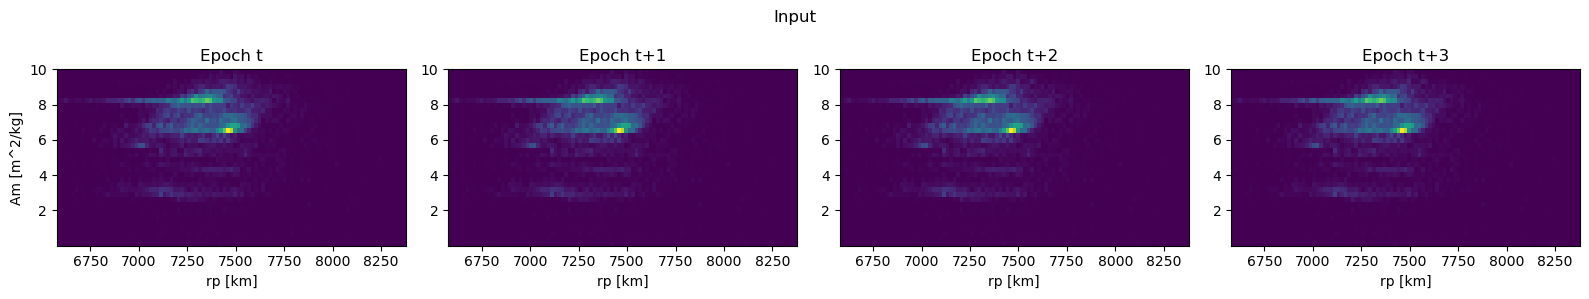

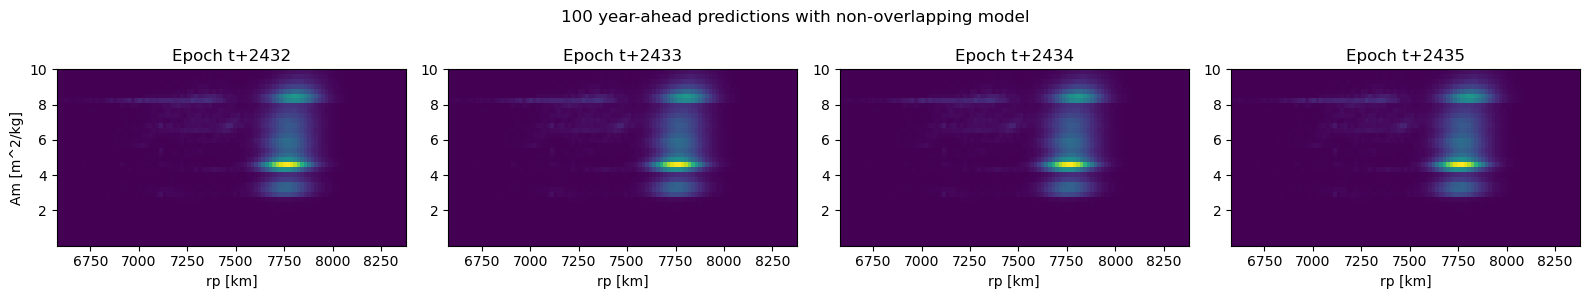

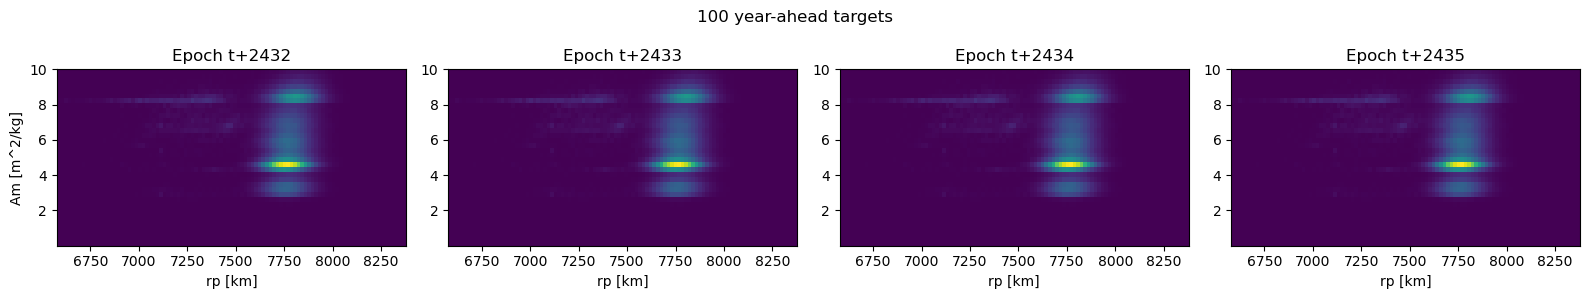

In [27]:
learn.show_preds_at(0, p=preds, t=targs, inp=inps, with_targets=True, 
                    with_input=True, start_epoch=(n_iter-1)*config.horizon,
                   titles=["Input", "100 year-ahead predictions with non-overlapping model", 
                           "100 year-ahead targets"])

In [21]:
# TODO: log plot with predictions

In [22]:
if config.wandb.enabled:
    wandb.log({'losses_per_iteration': losses})

In [23]:
if run is not None:
    run.finish()